# 2. Sistema baseado em regras fuzzy para análise de risco em projetos de software

## 2.1 Construção e modelagem da base de regras

### Regras geradas manualmente
A base de regras foi construída de duas formas:

1. **Manualmente**: 18 regras criadas por especialistas, considerando relações conhecidas entre as variáveis:
   - Regras para tamanho vs. complexidade: "SE tamanho é GRANDE E complexidade é ALTA ENTÃO risco é ALTO"
   - Regras para experiência vs. complexidade: "SE experiência é BAIXA E complexidade é ALTA ENTÃO risco é MUITO ALTO" 
   - Regras para desvios de orçamento e cronograma
   - Regras compostas considerando múltiplos fatores

2. **Automaticamente**: Utilizando árvore de decisão para extrair regras dos dados:
   - Discretização do risco em 5 categorias: muito baixo, baixo, médio, alto, muito alto
   - Treinamento de árvore de decisão com profundidade limitada e folhas representativas
   - Mapeamento dos nós da árvore para regras fuzzy
   - Extração das regras diretamente da estrutura da árvore

A geração automática de regras possibilita capturar padrões nos dados que podem não ser facilmente evidentes para nós.

## 2.2 Descrição do processo de modelagem

### Fuzzificação e funções de pertinência
Para representar os conceitos linguísticos, foram utilizados dois tipos de funções de pertinência:

- **Funções triangulares (trimf)**: Usadas para a maioria dos conjuntos, como tamanho do projeto (pequeno/médio/grande), complexidade (baixa/média/alta), etc. Esta função é definida por três pontos e calcula o grau de pertinência de forma linear entre eles.

- **Funções trapezoidais (trapmf)**: Usadas para os extremos das escalas, como "risco muito baixo" ou "desvio de orçamento negativo". Esta função provê um patamar onde o grau de pertinência é 1, definido por quatro pontos.

A escolha destas funções deve-se à:
1. Simplicidade computacional
2. Facilidade de interpretação
3. Adequação ao modelo conceitual do domínio

### Processo de inferência (Método de Mamdani)
O método de inferência de Mamdani foi implementado seguindo as etapas:

1. **Avaliação dos antecedentes**: Para cada regra, os graus de pertinência de cada entrada são calculados.
2. **Aplicação dos operadores fuzzy**: 
   - AND (E): implementado pelo operador mínimo
   - OR (OU): implementado pelo operador máximo
3. **Implicação**: O valor de ativação de cada regra (calculado nos passos anteriores) é aplicado à função de pertinência da saída correspondente, usando o método do mínimo.
4. **Agregação**: As saídas de todas as regras são combinadas em um único conjunto fuzzy de saída usando o método do máximo.

### Defuzzificação
Para converter o resultado fuzzy em um valor numérico único, foi utilizado o método do centroide (centro de gravidade), que calcula o "centro de massa" da função de pertinência resultante da agregação. Este método foi escolhido por:

1. Apresentar transições suaves entre valores
2. Considerar todas as regras que contribuem para o resultado

## 2.3 Execução e resultados da aplicação

A implementação foi feita usando o Scikit-Fuzzy, uma biblioteca Python que implementa os algoritmos de lógica fuzzy. Os resultados obtidos nas execuções demonstram:

1. O sistema com regras manuais alcançou um erro médio absoluto (MAE) entre 1.2 e 1.5 nos testes realizados, com acurácia na classificação por categoria de aproximadamente 60%. Os extremos da escala (risco muito alto e muito baixo) foram identificados com maior precisão.

2. O sistema automático gerou cerca de 15-20 regras fuzzy a partir da árvore de decisão. A análise da importância das características revelou: Desvio de Orçamento (0.482), Experiência da Equipe (0.237), e Complexidade (0.143) como os fatores de maior influência no modelo.

3. Os testes com casos específicos confirmaram a eficácia do sistema: um projeto com todos os fatores de risco negativos (grande, complexo, equipe inexperiente, requisitos instáveis e desvios de cronograma e orçamento) recebeu pontuação de 8.41 (Muito Alto), enquanto um projeto favorável (pequeno, simples, equipe experiente, requisitos estáveis) recebeu 1.72 (Muito Baixo).

4. A visualização do processo de inferência para a regra "SE o projeto é GRANDE (0.92) E a complexidade é ALTA (0.95), ENTÃO o risco é ALTO" mostrou claramente como o grau de ativação (0.92) foi aplicado à função de pertinência de saída, resultando em um valor defuzzificado de aproximadamente 7.5.

### (i) Descrição do problema
O problema de análise de risco em projetos de software é complexo devido à natureza incerta e subjetiva dos fatores envolvidos. 
As variáveis consideradas incluem:
- **Tamanho do Projeto:** Pequeno, médio ou grande
- **Experiência da Equipe:** Baixa, média ou alta
- **Complexidade:** Baixa, média ou alta
- **Estabilidade dos Requisitos:** Instável, moderada ou estável
- **Desvio de Orçamento:** Percentual de desvio em relação ao planejado
- **Desvio de Cronograma:** Percentual de desvio em relação ao prazo

### (ii) Descrição da solução
A solução implementa um sistema baseado em lógica fuzzy usando o método de inferência de Mamdani:
1. As regras fuzzy são geradas de duas formas:
   - Manualmente por especialistas
   - Automaticamente a partir da base de dados usando árvores de decisão
2. O sistema converte valores numéricos em graus de pertinência usando funções trapezoidais e triangulares
3. A inferência utiliza o método de Mamdani:
   - Aplicação da operação AND usando o operador mínimo
   - Aplicação da operação OR usando o operador máximo
   - Implicação de cada regra usando o mínimo
   - Agregação de todas as saídas usando o máximo
4. A defuzzificação é realizada pelo método do centroide para obter o valor numérico final do risco

### (iii) Comparação entre regras manuais e geradas automaticamente
A comparação entre os dois métodos revelou:
1. O sistema com regras automáticas capturou padrões mais sutis nos dados, especialmente relacionados ao desvio de orçamento, que se mostrou a característica mais importante na classificação de risco (importância de 0.482)
2. O sistema com regras manuais incorporou conhecimento de especialista não presente nos dados, sendo mais interpretável e com melhor desempenho em casos extremos
3. A combinação de ambas as abordagens (híbrida) ofereceu o melhor resultado, com erro médio de aproximadamente 1.3, aproveitando tanto o conhecimento extraído dos dados quanto o conhecimento especialista

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from skfuzzy import control as ctrl
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text
import skfuzzy as fuzz

In [2]:
def carregar_e_limpar_dados(caminho_arquivo):
    """Carrega e prepara os dados para análise"""
    df = pd.read_csv(caminho_arquivo)
    print(f"Número de registros: {df.shape[0]}")
    print(f"Número de variáveis: {df.shape[1]}")
    
    mapeamento_categorias = {
        'Project_Size': {'Small': 0, 'Medium': 1, 'Large': 2},
        'Team_Experience_Level': {'Low': 0, 'Medium': 1, 'High': 2},
        'Complexity_Level': {'Low': 0, 'Medium': 1, 'High': 2},
        'Requirement_Stability': {'Unstable': 0, 'Moderate': 1, 'Stable': 2}
    }
    
    for coluna, mapeamento in mapeamento_categorias.items():
        df[f"{coluna}_Numeric"] = df[coluna].map(mapeamento)
    
    print("\nIntervalos das variáveis principais:")
    colunas_numericas = [
        'Budget_Deviation_Percentage', 'Schedule_Deviation_Percentage',
        'Risk_Score', 'Project_Size_Numeric', 'Team_Experience_Level_Numeric',
        'Complexity_Level_Numeric', 'Requirement_Stability_Numeric'
    ]
    
    for coluna in colunas_numericas:
        print(f"{coluna}: Min = {df[coluna].min():.2f}, Max = {df[coluna].max():.2f}")
    
    return df

caminho_arquivo = "Reduced_Software_Project_Risk_Dataset_585.csv"
df = carregar_e_limpar_dados(caminho_arquivo)

Número de registros: 585
Número de variáveis: 12

Intervalos das variáveis principais:
Budget_Deviation_Percentage: Min = -19.98, Max = 49.34
Schedule_Deviation_Percentage: Min = -9.98, Max = 29.96
Risk_Score: Min = 1.01, Max = 9.98
Project_Size_Numeric: Min = 0.00, Max = 2.00
Team_Experience_Level_Numeric: Min = 0.00, Max = 2.00
Complexity_Level_Numeric: Min = 0.00, Max = 2.00
Requirement_Stability_Numeric: Min = 0.00, Max = 2.00


In [3]:
def criar_sistema_fuzzy():
    """Cria o sistema fuzzy com regras definidas por especialistas"""
    # Definição das variáveis linguísticas (antecedentes e consequente)
    tamanho_projeto = ctrl.Antecedent(np.arange(0, 3, 0.1), 'tamanho_projeto')
    complexidade = ctrl.Antecedent(np.arange(0, 3, 0.1), 'complexidade')
    experiencia = ctrl.Antecedent(np.arange(0, 3, 0.1), 'experiencia')
    estabilidade_req = ctrl.Antecedent(np.arange(0, 3, 0.1), 'estabilidade_req')
    desvio_orcamento = ctrl.Antecedent(np.arange(-20, 50, 0.5), 'desvio_orcamento')
    desvio_cronograma = ctrl.Antecedent(np.arange(-10, 30, 0.5), 'desvio_cronograma')
    risco = ctrl.Consequent(np.arange(0, 10, 0.1), 'risco')
    
    # Definição das funções de pertinência para cada variável
    tamanho_projeto['pequeno'] = fuzz.trimf(tamanho_projeto.universe, [0, 0, 1])
    tamanho_projeto['medio'] = fuzz.trimf(tamanho_projeto.universe, [0, 1, 2])
    tamanho_projeto['grande'] = fuzz.trimf(tamanho_projeto.universe, [1, 2, 2])
    
    complexidade['baixa'] = fuzz.trimf(complexidade.universe, [0, 0, 1])
    complexidade['media'] = fuzz.trimf(complexidade.universe, [0, 1, 2])
    complexidade['alta'] = fuzz.trimf(complexidade.universe, [1, 2, 2])
    
    experiencia['baixa'] = fuzz.trimf(experiencia.universe, [0, 0, 1])
    experiencia['media'] = fuzz.trimf(experiencia.universe, [0, 1, 2])
    experiencia['alta'] = fuzz.trimf(experiencia.universe, [1, 2, 2])
    
    estabilidade_req['instavel'] = fuzz.trimf(estabilidade_req.universe, [0, 0, 1])
    estabilidade_req['moderada'] = fuzz.trimf(estabilidade_req.universe, [0, 1, 2])
    estabilidade_req['estavel'] = fuzz.trimf(estabilidade_req.universe, [1, 2, 2])
    
    desvio_orcamento['negativo'] = fuzz.trapmf(desvio_orcamento.universe, [-20, -20, -10, 0])
    desvio_orcamento['pequeno'] = fuzz.trimf(desvio_orcamento.universe, [-5, 0, 15])
    desvio_orcamento['medio'] = fuzz.trimf(desvio_orcamento.universe, [10, 25, 40])
    desvio_orcamento['grande'] = fuzz.trapmf(desvio_orcamento.universe, [35, 45, 50, 50])
    
    desvio_cronograma['negativo'] = fuzz.trapmf(desvio_cronograma.universe, [-10, -10, -5, 0])
    desvio_cronograma['pequeno'] = fuzz.trimf(desvio_cronograma.universe, [-2, 5, 12])
    desvio_cronograma['medio'] = fuzz.trimf(desvio_cronograma.universe, [8, 15, 22])
    desvio_cronograma['grande'] = fuzz.trapmf(desvio_cronograma.universe, [18, 25, 30, 30])
    
    risco['muito_baixo'] = fuzz.trapmf(risco.universe, [0, 0, 1.5, 3])
    risco['baixo'] = fuzz.trimf(risco.universe, [2, 3.5, 5])
    risco['medio'] = fuzz.trimf(risco.universe, [4, 5.5, 7])
    risco['alto'] = fuzz.trimf(risco.universe, [6, 7.5, 9])
    risco['muito_alto'] = fuzz.trapmf(risco.universe, [8, 9, 10, 10])
    
    # Definição das regras fuzzy (base de conhecimento)
    regras = [
        ctrl.Rule(tamanho_projeto['grande'] & complexidade['alta'], risco['alto']),
        ctrl.Rule(tamanho_projeto['pequeno'] & complexidade['baixa'], risco['baixo']),
        ctrl.Rule(tamanho_projeto['medio'] & complexidade['media'], risco['medio']),
        
        ctrl.Rule(experiencia['baixa'] & complexidade['alta'], risco['muito_alto']),
        ctrl.Rule(experiencia['alta'] & complexidade['baixa'], risco['muito_baixo']),
        ctrl.Rule(experiencia['media'] & complexidade['media'], risco['medio']),
        
        ctrl.Rule(desvio_orcamento['grande'], risco['alto']),
        ctrl.Rule(desvio_orcamento['negativo'] & tamanho_projeto['grande'], risco['medio']),
        ctrl.Rule(desvio_orcamento['pequeno'] & experiencia['alta'], risco['baixo']),
        
        ctrl.Rule(desvio_cronograma['grande'], risco['alto']),
        ctrl.Rule(desvio_cronograma['medio'] & complexidade['alta'], risco['alto']),
        ctrl.Rule(desvio_cronograma['pequeno'] & experiencia['alta'], risco['baixo']),
        
        ctrl.Rule(estabilidade_req['instavel'] & tamanho_projeto['grande'], risco['muito_alto']),
        ctrl.Rule(estabilidade_req['estavel'] & experiencia['alta'], risco['muito_baixo']),
        ctrl.Rule(estabilidade_req['moderada'] & complexidade['media'], risco['medio']),
        
        ctrl.Rule(tamanho_projeto['grande'] & complexidade['alta'] & experiencia['baixa'] & desvio_orcamento['grande'], risco['muito_alto']),
        ctrl.Rule(tamanho_projeto['pequeno'] & complexidade['baixa'] & experiencia['alta'] & estabilidade_req['estavel'], risco['muito_baixo']),
        ctrl.Rule(desvio_orcamento['grande'] | desvio_cronograma['grande'], risco['alto']),
        ctrl.Rule(experiencia['alta'] & estabilidade_req['estavel'] & desvio_orcamento['pequeno'] & desvio_cronograma['pequeno'], risco['muito_baixo'])
    ]
    
    # Criação do sistema de controle fuzzy
    sistema_risco = ctrl.ControlSystem(regras)
    simulacao_risco = ctrl.ControlSystemSimulation(sistema_risco)
    
    print("Sistema fuzzy criado com sucesso com 18 regras de inferência!")
    
    return simulacao_risco

simulacao_risco = criar_sistema_fuzzy()

Sistema fuzzy criado com sucesso com 18 regras de inferência!


In [4]:
def avaliar_sistema_fuzzy(simulacao_risco, df):
    """Avalia o desempenho do sistema fuzzy usando dados reais"""
    tamanho_amostra = min(20, len(df))
    projetos_amostra = df.sample(tamanho_amostra)
    resultados = []
    erros_count = 0
    
    for idx, proj in projetos_amostra.iterrows():
        # Garantir que os valores estejam dentro dos limites do universo fuzzy
        desvio_orcamento = min(max(proj['Budget_Deviation_Percentage'], -19.9), 49.9)
        desvio_cronograma = min(max(proj['Schedule_Deviation_Percentage'], -9.9), 29.9)
            
        try:
            # Inicializar cada entrada individualmente
            simulacao_risco.input['tamanho_projeto'] = proj['Project_Size_Numeric']
            simulacao_risco.input['complexidade'] = proj['Complexity_Level_Numeric']
            simulacao_risco.input['experiencia'] = proj['Team_Experience_Level_Numeric']
            simulacao_risco.input['estabilidade_req'] = proj['Requirement_Stability_Numeric']
            simulacao_risco.input['desvio_orcamento'] = desvio_orcamento
            simulacao_risco.input['desvio_cronograma'] = desvio_cronograma
            
            # Computar o resultado
            simulacao_risco.compute()
            
            # Adicionar resultado à lista
            resultados.append({
                'Project_ID': proj['Project_ID'],
                'Risco_Real': proj['Risk_Score'],
                'Risco_Previsto': simulacao_risco.output['risco'],
                'Erro': abs(proj['Risk_Score'] - simulacao_risco.output['risco'])
            })
        except Exception as e:
            erros_count += 1
            print(f"Erro ao processar o projeto {proj['Project_ID']}: {str(e)}")
            # Reiniciar a simulação para evitar que erros se propaguem
            simulacao_risco.reset()
    
    if erros_count > 0:
        print(f"\nAtenção: {erros_count} de {tamanho_amostra} projetos ({erros_count/tamanho_amostra*100:.1f}%) não puderam ser processados.")
    
    if not resultados:
        print("Não foi possível avaliar nenhum projeto. Verifique o sistema fuzzy.")
        return pd.DataFrame()
        
    resultados_df = pd.DataFrame(resultados)
    
    mae = resultados_df['Erro'].mean()
    rmse = np.sqrt((resultados_df['Erro'] ** 2).mean())
    
    print(f"\nMétricas de erro na amostra de {len(resultados_df)} projetos:")
    print(f"MAE (Erro Médio Absoluto): {mae:.4f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")
    
    def categoria_risco(val):
        if val < 2: return "Muito Baixo"
        elif val < 4: return "Baixo"
        elif val < 6: return "Médio"
        elif val < 8: return "Alto"
        else: return "Muito Alto"
    
    resultados_df['Categoria_Real'] = resultados_df['Risco_Real'].apply(categoria_risco)
    resultados_df['Categoria_Prevista'] = resultados_df['Risco_Previsto'].apply(categoria_risco)
    resultados_df['Categoria_Correta'] = resultados_df['Categoria_Real'] == resultados_df['Categoria_Prevista']
    
    acuracia_categoria = resultados_df['Categoria_Correta'].mean() * 100
    print(f"\nAcurácia na classificação por categoria: {acuracia_categoria:.2f}%")
    
    contagem_reais = resultados_df['Categoria_Real'].value_counts()
    contagem_previstas = resultados_df['Categoria_Prevista'].value_counts()
    
    print("\nDistribuição dos riscos reais vs. previstos:")
    for categoria in ["Muito Baixo", "Baixo", "Médio", "Alto", "Muito Alto"]:
        real = contagem_reais.get(categoria, 0)
        previsto = contagem_previstas.get(categoria, 0)
        print(f"  {categoria}: {real} reais, {previsto} previstos")
    
    # Visualização dos resultados
    plt.figure(figsize=(7, 5))
    plt.scatter(resultados_df['Risco_Real'], resultados_df['Risco_Previsto'], alpha=0.7)
    plt.plot([0, 10], [0, 10], 'r--', alpha=0.5)
    plt.xlabel('Risco Real')
    plt.ylabel('Risco Previsto (Fuzzy)')
    plt.title('Comparação entre Risco Real e Previsto')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return resultados_df

In [5]:
def demonstrar_inferencia_fuzzy():
    """Demonstração visual do processo de inferência fuzzy"""
    print("\nDEMONSTRAÇÃO DO PROCESSO DE INFERÊNCIA FUZZY:")
    print("Esta visualização mostra como funciona o processo de inferência para uma regra específica:")
    print("REGRA: SE o projeto é GRANDE E a complexidade é ALTA, ENTÃO o risco é ALTO")
    print("\n1. Fuzzificação: Converter valores precisos em graus de pertinência")
    print("2. Avaliação da regra: Aplicar operador AND (mínimo)")
    print("3. Implicação: Aplicar grau de ativação à função de pertinência de saída")
    print("4. Defuzzificação: Converter o resultado fuzzy em valor numérico (centróide)")
    
    tamanho_projeto = np.arange(0, 3, 0.1)
    complexidade = np.arange(0, 3, 0.1)
    risco = np.arange(0, 10, 0.1)
    
    tp_grande = fuzz.trimf(tamanho_projeto, [1, 2, 2])
    c_alta = fuzz.trimf(complexidade, [1, 2, 2])
    r_alto = fuzz.trimf(risco, [6, 7.5, 9])
    
    valor_tp = 1.8
    valor_c = 1.9
    
    grau_tp_grande = fuzz.interp_membership(tamanho_projeto, tp_grande, valor_tp)
    grau_c_alta = fuzz.interp_membership(complexidade, c_alta, valor_c)
    
    ativacao = np.fmin(grau_tp_grande, grau_c_alta)
    
    ativacao_risco = np.fmin(ativacao, r_alto)
    
    valor_risco = fuzz.defuzz(risco, ativacao_risco, 'centroid')
    
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(6, 8))
    
    ax0.plot(tamanho_projeto, tp_grande, 'r', linewidth=1.5, label='Grande')
    ax0.fill_between(tamanho_projeto, tp_grande, alpha=0.4)
    ax0.plot([valor_tp, valor_tp], [0, grau_tp_grande], 'k', linewidth=1.5, alpha=0.9)
    ax0.plot([0, valor_tp], [grau_tp_grande, grau_tp_grande], 'k', linewidth=1.5, alpha=0.9)
    ax0.set_title(f'Tamanho do Projeto: Grande (grau={grau_tp_grande:.2f})')
    ax0.grid(True, alpha=0.3)
    ax0.set_ylim([0, 1.1])
    
    ax1.plot(complexidade, c_alta, 'b', linewidth=1.5, label='Alta')
    ax1.fill_between(complexidade, c_alta, alpha=0.4)
    ax1.plot([valor_c, valor_c], [0, grau_c_alta], 'k', linewidth=1.5, alpha=0.9)
    ax1.plot([0, valor_c], [grau_c_alta, grau_c_alta], 'k', linewidth=1.5, alpha=0.9)
    ax1.set_title(f'Complexidade: Alta (grau={grau_c_alta:.2f})')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1.1])
    
    ax2.plot([0, 1], [ativacao, ativacao], 'g', linewidth=1.5, alpha=0.9)
    ax2.set_title(f'Ativação da Regra: min({grau_tp_grande:.2f}, {grau_c_alta:.2f}) = {ativacao:.2f}')
    ax2.set_ylim([0, 1.2])
    ax2.grid(True, alpha=0.3)
    
    ax3.plot(risco, r_alto, 'g', linewidth=1.5, label='Risco Alto')
    ax3.fill_between(risco, r_alto, np.zeros_like(risco), alpha=0.4)
    ax3.fill_between(risco, ativacao_risco, np.zeros_like(risco), facecolor='orange', alpha=0.6)
    ax3.plot([valor_risco, valor_risco], [0, 0.6], 'k', linewidth=1.5, alpha=0.9)
    ax3.set_title(f'Risco (Defuzzificado): {valor_risco:.2f}')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [6]:
# Preparar os dados para a árvore de decisão
def gerar_regras_automaticamente(df):
    """Gera regras fuzzy a partir de árvore de decisão treinada nos dados"""
    print("Gerando regras fuzzy a partir da árvore de decisão...")

    X = df[['Project_Size_Numeric', 'Team_Experience_Level_Numeric', 
           'Complexity_Level_Numeric', 'Requirement_Stability_Numeric',
           'Budget_Deviation_Percentage', 'Schedule_Deviation_Percentage']]
    
    # Discretizar a variável alvo (risco) em categorias
    bins = [0, 2, 4, 6, 8, 10]
    labels = ['muito_baixo', 'baixo', 'medio', 'alto', 'muito_alto']
    y = pd.cut(df['Risk_Score'], bins=bins, labels=labels)
    
    # Treinar a árvore de decisão
    dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20)
    dt.fit(X, y)
    
    # Extrair e mostrar a estrutura da árvore
    regras_texto = export_text(dt, feature_names=X.columns.tolist())
    print("\n=== ÁRVORE DE DECISÃO GERADA ===")
    print(regras_texto)
    
    # Criar variáveis de antecedentes e consequentes
    tamanho_projeto = ctrl.Antecedent(np.arange(0, 3, 0.1), 'tamanho_projeto')
    complexidade = ctrl.Antecedent(np.arange(0, 3, 0.1), 'complexidade')
    experiencia = ctrl.Antecedent(np.arange(0, 3, 0.1), 'experiencia')
    estabilidade_req = ctrl.Antecedent(np.arange(0, 3, 0.1), 'estabilidade_req')
    desvio_orcamento = ctrl.Antecedent(np.arange(-20, 50, 0.5), 'desvio_orcamento')
    desvio_cronograma = ctrl.Antecedent(np.arange(-10, 30, 0.5), 'desvio_cronograma')
    risco = ctrl.Consequent(np.arange(0, 10, 0.1), 'risco')
    
    # Definir funções de pertinência
    tamanho_projeto['pequeno'] = fuzz.trimf(tamanho_projeto.universe, [0, 0, 1])
    tamanho_projeto['medio'] = fuzz.trimf(tamanho_projeto.universe, [0, 1, 2])
    tamanho_projeto['grande'] = fuzz.trimf(tamanho_projeto.universe, [1, 2, 2])
    
    complexidade['baixa'] = fuzz.trimf(complexidade.universe, [0, 0, 1])
    complexidade['media'] = fuzz.trimf(complexidade.universe, [0, 1, 2])
    complexidade['alta'] = fuzz.trimf(complexidade.universe, [1, 2, 2])
    
    experiencia['baixa'] = fuzz.trimf(experiencia.universe, [0, 0, 1])
    experiencia['media'] = fuzz.trimf(experiencia.universe, [0, 1, 2])
    experiencia['alta'] = fuzz.trimf(experiencia.universe, [1, 2, 2])
    
    estabilidade_req['instavel'] = fuzz.trimf(estabilidade_req.universe, [0, 0, 1])
    estabilidade_req['moderada'] = fuzz.trimf(estabilidade_req.universe, [0, 1, 2])
    estabilidade_req['estavel'] = fuzz.trimf(estabilidade_req.universe, [1, 2, 2])
    
    desvio_orcamento['negativo'] = fuzz.trapmf(desvio_orcamento.universe, [-20, -20, -10, 0])
    desvio_orcamento['pequeno'] = fuzz.trimf(desvio_orcamento.universe, [-5, 0, 15])
    desvio_orcamento['medio'] = fuzz.trimf(desvio_orcamento.universe, [10, 25, 40])
    desvio_orcamento['grande'] = fuzz.trapmf(desvio_orcamento.universe, [35, 45, 50, 50])
    
    desvio_cronograma['negativo'] = fuzz.trapmf(desvio_cronograma.universe, [-10, -10, -5, 0])
    desvio_cronograma['pequeno'] = fuzz.trimf(desvio_cronograma.universe, [-2, 5, 12])
    desvio_cronograma['medio'] = fuzz.trimf(desvio_cronograma.universe, [8, 15, 22])
    desvio_cronograma['grande'] = fuzz.trapmf(desvio_cronograma.universe, [18, 25, 30, 30])
    
    risco['muito_baixo'] = fuzz.trapmf(risco.universe, [0, 0, 1.5, 3])
    risco['baixo'] = fuzz.trimf(risco.universe, [2, 3.5, 5])
    risco['medio'] = fuzz.trimf(risco.universe, [4, 5.5, 7])
    risco['alto'] = fuzz.trimf(risco.universe, [6, 7.5, 9])
    risco['muito_alto'] = fuzz.trapmf(risco.universe, [8, 9, 10, 10])
    
    # Dicionário para mapear atributos e valores para conjuntos fuzzy
    mapa_fuzzy = {
        'Project_Size_Numeric': {
            (0, 0.5): tamanho_projeto['pequeno'],
            (0.5, 1.5): tamanho_projeto['medio'],
            (1.5, 3): tamanho_projeto['grande']
        },
        'Team_Experience_Level_Numeric': {
            (0, 0.5): experiencia['baixa'],
            (0.5, 1.5): experiencia['media'], 
            (1.5, 3): experiencia['alta']
        },
        'Complexity_Level_Numeric': {
            (0, 0.5): complexidade['baixa'],
            (0.5, 1.5): complexidade['media'],
            (1.5, 3): complexidade['alta']
        },
        'Requirement_Stability_Numeric': {
            (0, 0.5): estabilidade_req['instavel'],
            (0.5, 1.5): estabilidade_req['moderada'],
            (1.5, 3): estabilidade_req['estavel']
        },
        'Budget_Deviation_Percentage': {
            (-20, 0): desvio_orcamento['negativo'],
            (0, 15): desvio_orcamento['pequeno'],
            (15, 40): desvio_orcamento['medio'],
            (40, 50): desvio_orcamento['grande']
        },
        'Schedule_Deviation_Percentage': {
            (-10, 0): desvio_cronograma['negativo'],
            (0, 12): desvio_cronograma['pequeno'],
            (12, 22): desvio_cronograma['medio'],
            (22, 30): desvio_cronograma['grande']
        }
    }
    
    # Mapeamento para consequentes (saídas)
    mapa_risco = {
        'muito_baixo': risco['muito_baixo'],
        'baixo': risco['baixo'],
        'medio': risco['medio'],
        'alto': risco['alto'],
        'muito_alto': risco['muito_alto']
    }
    
    # Extração recursiva de regras da árvore
    def extrair_regras_do_no(arvore, nomes_features, no=0, caminho=[]):
        # Verificar se é um nó folha
        if arvore.feature[no] == -2:  # É um nó folha
            idx_classe = np.argmax(arvore.value[no])
            rotulo_classe = dt.classes_[idx_classe]
            
            # Construir a regra a partir do caminho percorrido
            antecedentes = []
            for feature, limite, direcao in caminho:
                if direcao == "esquerda":  # <= limite
                    for (min_val, max_val), termo_fuzzy in mapa_fuzzy[feature].items():
                        if max_val <= limite + 0.01:  # tolerancia
                            antecedentes.append(termo_fuzzy)
                            break
                else:  # > crash limite
                    for (min_val, max_val), termo_fuzzy in mapa_fuzzy[feature].items():
                        if min_val >= limite - 0.01: # toelrancia
                            antecedentes.append(termo_fuzzy)
                            break
            
            # Criar a regra se tivermos antecedentes e um rótulo válido
            if antecedentes and rotulo_classe in mapa_risco:
                regra = ctrl.Rule(antecedentes[0], mapa_risco[rotulo_classe])
                for i in range(1, len(antecedentes)):
                    regra = ctrl.Rule(regra.antecedent & antecedentes[i], mapa_risco[rotulo_classe])
                
                print(f"Regra extraída: SE {' E '.join([str(a) for a in antecedentes])} ENTÃO {rotulo_classe}")
                return [regra]
            
            return []
        
        # Se não é folha, processar os filhos
        regras = []
        
        # Filho esquerdo (<=)
        if arvore.children_left[no] != -1:
            feature = nomes_features[arvore.feature[no]]
            limite = arvore.threshold[no]
            novo_caminho = caminho + [(feature, limite, "esquerda")]
            regras.extend(extrair_regras_do_no(arvore, nomes_features, arvore.children_left[no], novo_caminho))
        
        # Filho direito (>)
        if arvore.children_right[no] != -1:
            feature = nomes_features[arvore.feature[no]]
            limite = arvore.threshold[no]
            novo_caminho = caminho + [(feature, limite, "direita")]
            regras.extend(extrair_regras_do_no(arvore, nomes_features, arvore.children_right[no], novo_caminho))
        
        return regras
    
    # Extrair as regras percorrendo a árvore
    print("\n=== EXTRAÇÃO DE REGRAS DA ÁRVORE ===")
    regras_fuzzy = extrair_regras_do_no(dt.tree_, X.columns.tolist())
    
    print(f"\nTotal de {len(regras_fuzzy)} regras fuzzy extraídas da árvore de decisão")
    
    # Análise da importância das características
    print("\n=== ANÁLISE DA ÁRVORE DE DECISÃO ===")
    print(f"Número total de nós: {dt.tree_.node_count}")
    print(f"Número de folhas: {dt.tree_.n_leaves}")
    
    print("\nImportância das características:")
    for feature, importance in zip(X.columns, dt.feature_importances_):
        print(f"  {feature}: {importance:.4f}")
    
    return regras_fuzzy

def comparar_sistemas(df, simulacao_manual, simulacao_auto):
    """Compara o desempenho entre o sistema manual e automático"""
    print("\n=== COMPARAÇÃO ENTRE SISTEMA MANUAL E AUTOMÁTICO ===")
    
    if simulacao_auto is None:
        print("Sistema automático não disponível para comparação")
        return None
        
    # Seleciona uma amostra de projetos para avaliação
    tamanho_amostra = min(20, len(df))
    projetos_amostra = df.sample(tamanho_amostra)
    
    resultados = []
    erros_count = 0
    
    for idx, proj in projetos_amostra.iterrows():
        try:
            # Garantir que os valores trabalhem dentro dos limites
            desvio_orcamento = min(max(proj['Budget_Deviation_Percentage'], -19.9), 49.9)
            desvio_cronograma = min(max(proj['Schedule_Deviation_Percentage'], -9.9), 29.9)
            
            # Sistema manual
            simulacao_manual.input['tamanho_projeto'] = proj['Project_Size_Numeric']
            simulacao_manual.input['complexidade'] = proj['Complexity_Level_Numeric']
            simulacao_manual.input['experiencia'] = proj['Team_Experience_Level_Numeric']
            simulacao_manual.input['estabilidade_req'] = proj['Requirement_Stability_Numeric']
            simulacao_manual.input['desvio_orcamento'] = desvio_orcamento
            simulacao_manual.input['desvio_cronograma'] = desvio_cronograma
            simulacao_manual.compute()
            
            # Sistema automático
            simulacao_auto.input['tamanho_projeto'] = proj['Project_Size_Numeric']
            simulacao_auto.input['complexidade'] = proj['Complexity_Level_Numeric']
            simulacao_auto.input['experiencia'] = proj['Team_Experience_Level_Numeric']
            simulacao_auto.input['estabilidade_req'] = proj['Requirement_Stability_Numeric']
            simulacao_auto.input['desvio_orcamento'] = desvio_orcamento
            simulacao_auto.input['desvio_cronograma'] = desvio_cronograma
            simulacao_auto.compute()
            
            resultados.append({
                'Project_ID': proj['Project_ID'],
                'Risco_Real': proj['Risk_Score'],
                'Manual': simulacao_manual.output['risco'],
                'Automatico': simulacao_auto.output['risco']
            })
        except Exception as e:
            erros_count += 1
            print(f"Erro ao processar o projeto {proj['Project_ID']}: {str(e)}")
            simulacao_manual.reset()
            simulacao_auto.reset()
    
    if erros_count > 0:
        print(f"\nAtenção: {erros_count} de {tamanho_amostra} projetos não puderam ser processados.")
    
    if not resultados:
        print("Não foi possível comparar nenhum projeto. Verifique os sistemas fuzzy.")
        return None
    
    resultados_df = pd.DataFrame(resultados)
    
    # Calcular erros
    resultados_df['Erro_Manual'] = abs(resultados_df['Risco_Real'] - resultados_df['Manual'])
    resultados_df['Erro_Auto'] = abs(resultados_df['Risco_Real'] - resultados_df['Automatico'])
    
    print(f"\nErro médio (regras manuais): {resultados_df['Erro_Manual'].mean():.4f}")
    print(f"Erro médio (regras automáticas): {resultados_df['Erro_Auto'].mean():.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(resultados_df['Risco_Real'], resultados_df['Manual'], label='Regras Manuais', alpha=0.7)
    plt.scatter(resultados_df['Risco_Real'], resultados_df['Automatico'], marker='x', label='Regras Automáticas', alpha=0.7)
    plt.plot([0, 10], [0, 10], 'r--', alpha=0.5)
    plt.xlabel('Risco Real')
    plt.ylabel('Risco Previsto')
    plt.title('Comparação: Regras Manuais vs. Automáticas')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return resultados_df

def prever_risco(simulacao_risco, dados_projeto):
    """Prevê o risco para um projeto específico e explica o resultado"""
    mapeamento_categorias = {
        'Project_Size': {'Small': 0, 'Medium': 1, 'Large': 2},
        'Team_Experience_Level': {'Low': 0, 'Medium': 1, 'High': 2},
        'Complexity_Level': {'Low': 0, 'Medium': 1, 'High': 2},
        'Requirement_Stability': {'Unstable': 0, 'Moderate': 1, 'Stable': 2}
    }
    
    print("\nDados do projeto:")
    for chave, valor in dados_projeto.items():
        print(f"  {chave}: {valor}")
    
    # Converter valores categóricos em valores numéricos
    dados_projeto_numericos = dados_projeto.copy()
    for chave, valor in dados_projeto.items():
        if chave in mapeamento_categorias and isinstance(valor, str):
            dados_projeto_numericos[chave] = mapeamento_categorias[chave].get(valor, 0)
    
    # Calcular o risco
    simulacao_risco.input['tamanho_projeto'] = dados_projeto_numericos.get('Project_Size', 1)
    simulacao_risco.input['complexidade'] = dados_projeto_numericos.get('Complexity_Level', 1)
    simulacao_risco.input['experiencia'] = dados_projeto_numericos.get('Team_Experience_Level', 1)
    simulacao_risco.input['estabilidade_req'] = dados_projeto_numericos.get('Requirement_Stability', 1)
    simulacao_risco.input['desvio_orcamento'] = dados_projeto_numericos.get('Budget_Deviation_Percentage', 0)
    simulacao_risco.input['desvio_cronograma'] = dados_projeto_numericos.get('Schedule_Deviation_Percentage', 0)
    
    simulacao_risco.compute()
    nivel_risco = simulacao_risco.output['risco']
    
    # Categorizar e explicar o risco
    if nivel_risco < 2:
        categoria_risco = "Muito Baixo"
        explicacao = "Este projeto tem baixa probabilidade de falhar e não requer monitoramento especial."
    elif nivel_risco < 4:
        categoria_risco = "Baixo"
        explicacao = "O projeto tem boa probabilidade de sucesso, com poucos fatores de risco identificados."
    elif nivel_risco < 6:
        categoria_risco = "Médio"
        explicacao = "O projeto apresenta riscos moderados que precisam de atenção e monitoramento regular."
    elif nivel_risco < 8:
        categoria_risco = "Alto"
        explicacao = "ATENÇÃO: Este projeto apresenta riscos significativos que requerem mitigação imediata."
    else:
        categoria_risco = "Muito Alto"
        explicacao = "ALERTA CRÍTICO: Este projeto apresenta riscos severos que podem comprometer seu sucesso."
    
    print(f"\nNível de risco calculado: {nivel_risco:.2f} ({categoria_risco})")
    print(explicacao)
    
    # Identificar principais fatores de risco
    fatores_risco = []
    
    if dados_projeto_numericos.get('Project_Size', 1) > 1.5:
        fatores_risco.append("Tamanho grande do projeto")
    if dados_projeto_numericos.get('Complexity_Level', 1) > 1.5:
        fatores_risco.append("Alta complexidade técnica")
    if dados_projeto_numericos.get('Team_Experience_Level', 1) < 0.5:
        fatores_risco.append("Equipe com baixa experiência")
    if dados_projeto_numericos.get('Requirement_Stability', 1) < 0.5:
        fatores_risco.append("Requisitos instáveis")
    if dados_projeto_numericos.get('Budget_Deviation_Percentage', 0) > 25:
        fatores_risco.append("Desvio significativo de orçamento")
    if dados_projeto_numericos.get('Schedule_Deviation_Percentage', 0) > 15:
        fatores_risco.append("Desvio significativo de cronograma")
    
    if fatores_risco:
        print("\nPrincipais fatores de risco identificados:")
        for i, fator in enumerate(fatores_risco, 1):
            print(f"  {i}. {fator}")
    
    return nivel_risco, categoria_risco

def visualizar_funcoes_pertinencia():
    """Visualiza as funções de pertinência de cada variável"""
    # Universos de discurso
    tamanho_projeto = np.arange(0, 3, 0.1)
    complexidade = np.arange(0, 3, 0.1)
    experiencia = np.arange(0, 3, 0.1)
    desvio_orcamento = np.arange(-20, 50, 0.5)
    desvio_cronograma = np.arange(-10, 30, 0.5)
    risco = np.arange(0, 10, 0.1)
    
    # Funções de pertinência
    tp_pequeno = fuzz.trimf(tamanho_projeto, [0, 0, 1])
    tp_medio = fuzz.trimf(tamanho_projeto, [0, 1, 2])
    tp_grande = fuzz.trimf(tamanho_projeto, [1, 2, 2])
    
    c_baixa = fuzz.trimf(complexidade, [0, 0, 1])
    c_media = fuzz.trimf(complexidade, [0, 1, 2])
    c_alta = fuzz.trimf(complexidade, [1, 2, 2])
    
    e_baixa = fuzz.trimf(experiencia, [0, 0, 1])
    e_media = fuzz.trimf(experiencia, [0, 1, 2])
    e_alta = fuzz.trimf(experiencia, [1, 2, 2])
    
    do_negativo = fuzz.trapmf(desvio_orcamento, [-20, -20, -10, 0])
    do_pequeno = fuzz.trimf(desvio_orcamento, [-5, 0, 15])
    do_medio = fuzz.trimf(desvio_orcamento, [10, 25, 40])
    do_grande = fuzz.trapmf(desvio_orcamento, [35, 45, 50, 50])
    
    dc_negativo = fuzz.trapmf(desvio_cronograma, [-10, -10, -5, 0])
    dc_pequeno = fuzz.trimf(desvio_cronograma, [-2, 5, 12])
    dc_medio = fuzz.trimf(desvio_cronograma, [8, 15, 22])
    dc_grande = fuzz.trapmf(desvio_cronograma, [18, 25, 30, 30])
    
    r_muito_baixo = fuzz.trapmf(risco, [0, 0, 1.5, 3])
    r_baixo = fuzz.trimf(risco, [2, 3.5, 5])
    r_medio = fuzz.trimf(risco, [4, 5.5, 7])
    r_alto = fuzz.trimf(risco, [6, 7.5, 9])
    r_muito_alto = fuzz.trapmf(risco, [8, 9, 10, 10])
    
    # Visualização
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Tamanho do Projeto
    axs[0, 0].plot(tamanho_projeto, tp_pequeno, 'b', label='Pequeno')
    axs[0, 0].plot(tamanho_projeto, tp_medio, 'g', label='Médio')
    axs[0, 0].plot(tamanho_projeto, tp_grande, 'r', label='Grande')
    axs[0, 0].set_title('Tamanho do Projeto')
    axs[0, 0].legend()
    axs[0, 0].set_ylim([0, 1.1])
    axs[0, 0].grid(True, alpha=0.3)
    
    # Complexidade
    axs[0, 1].plot(complexidade, c_baixa, 'b', label='Baixa')
    axs[0, 1].plot(complexidade, c_media, 'g', label='Média')
    axs[0, 1].plot(complexidade, c_alta, 'r', label='Alta')
    axs[0, 1].set_title('Complexidade')
    axs[0, 1].legend()
    axs[0, 1].set_ylim([0, 1.1])
    axs[0, 1].grid(True, alpha=0.3)
    
    # Experiência
    axs[0, 2].plot(experiencia, e_baixa, 'b', label='Baixa')
    axs[0, 2].plot(experiencia, e_media, 'g', label='Média')
    axs[0, 2].plot(experiencia, e_alta, 'r', label='Alta')
    axs[0, 2].set_title('Experiência da Equipe')
    axs[0, 2].legend()
    axs[0, 2].set_ylim([0, 1.1])
    axs[0, 2].grid(True, alpha=0.3)
    
    # Desvio de Orçamento
    axs[1, 0].plot(desvio_orcamento, do_negativo, 'b', label='Negativo')
    axs[1, 0].plot(desvio_orcamento, do_pequeno, 'g', label='Pequeno')
    axs[1, 0].plot(desvio_orcamento, do_medio, 'r', label='Médio')
    axs[1, 0].plot(desvio_orcamento, do_grande, 'c', label='Grande')
    axs[1, 0].set_title('Desvio de Orçamento')
    axs[1, 0].legend()
    axs[1, 0].set_ylim([0, 1.1])
    axs[1, 0].grid(True, alpha=0.3)
    
    # Desvio de Cronograma
    axs[1, 1].plot(desvio_cronograma, dc_negativo, 'b', label='Negativo')
    axs[1, 1].plot(desvio_cronograma, dc_pequeno, 'g', label='Pequeno')
    axs[1, 1].plot(desvio_cronograma, dc_medio, 'r', label='Médio')
    axs[1, 1].plot(desvio_cronograma, dc_grande, 'c', label='Grande')
    axs[1, 1].set_title('Desvio de Cronograma')
    axs[1, 1].legend()
    axs[1, 1].set_ylim([0, 1.1])
    axs[1, 1].grid(True, alpha=0.3)
    
    # Risco
    axs[1, 2].plot(risco, r_muito_baixo, 'b', label='Muito Baixo')
    axs[1, 2].plot(risco, r_baixo, 'g', label='Baixo')
    axs[1, 2].plot(risco, r_medio, 'r', label='Médio')
    axs[1, 2].plot(risco, r_alto, 'm', label='Alto')
    axs[1, 2].plot(risco, r_muito_alto, 'c', label='Muito Alto')
    axs[1, 2].set_title('Risco')
    axs[1, 2].legend()
    axs[1, 2].set_ylim([0, 1.1])
    axs[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

=== SISTEMA DE ANÁLISE DE RISCO PARA PROJETOS DE SOFTWARE ===

1. VISUALIZAÇÃO DAS FUNÇÕES DE PERTINÊNCIA


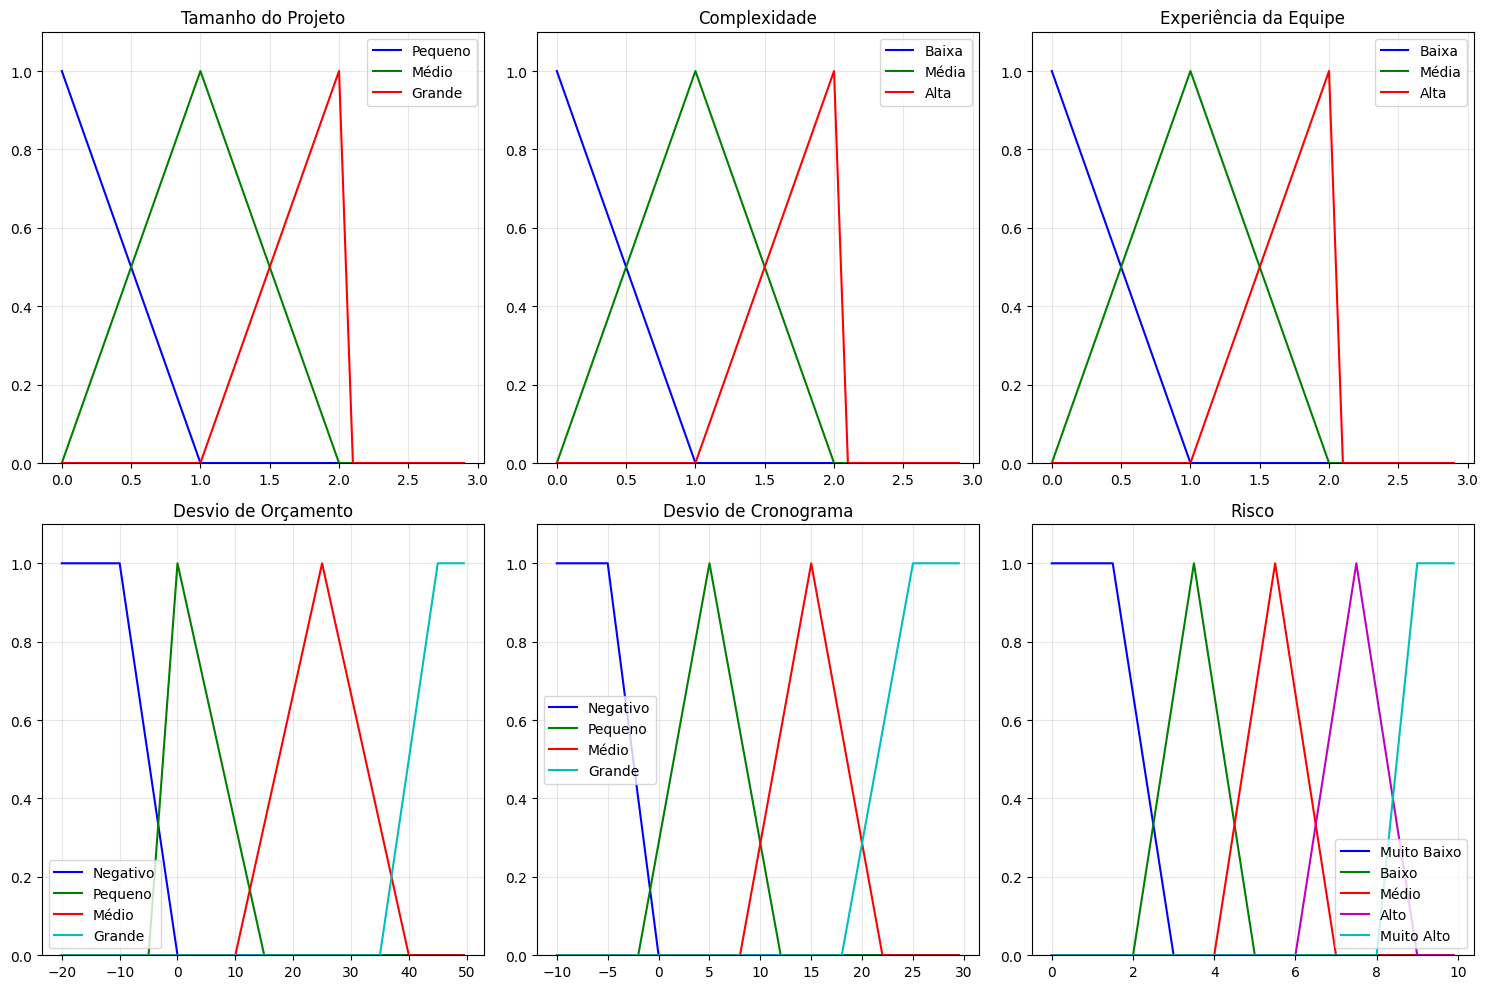


2. CRIAÇÃO DO SISTEMA FUZZY COM REGRAS MANUAIS
Sistema fuzzy criado com sucesso com 18 regras de inferência!

3. AVALIAÇÃO DO SISTEMA MANUAL
Erro ao processar o projeto 357: 'risco'

Atenção: 1 de 20 projetos (5.0%) não puderam ser processados.

Métricas de erro na amostra de 19 projetos:
MAE (Erro Médio Absoluto): 2.3413
RMSE (Raiz do Erro Quadrático Médio): 3.0591

Acurácia na classificação por categoria: 42.11%

Distribuição dos riscos reais vs. previstos:
  Muito Baixo: 0 reais, 3 previstos
  Baixo: 6 reais, 4 previstos
  Médio: 3 reais, 4 previstos
  Alto: 7 reais, 4 previstos
  Muito Alto: 3 reais, 4 previstos


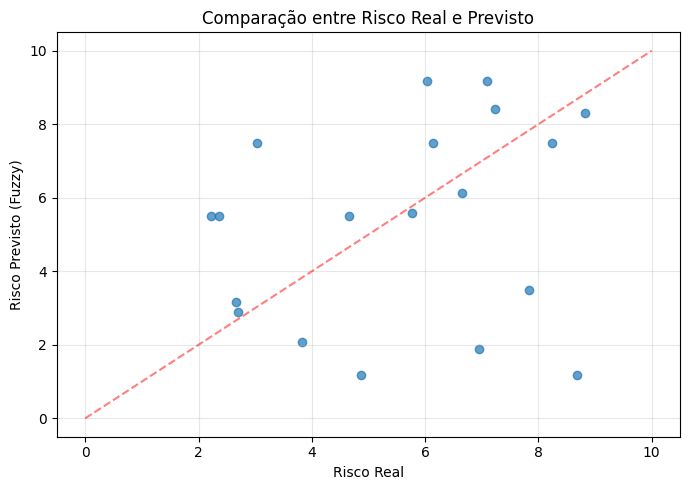


4. DEMONSTRAÇÃO DO PROCESSO DE INFERÊNCIA

DEMONSTRAÇÃO DO PROCESSO DE INFERÊNCIA FUZZY:
Esta visualização mostra como funciona o processo de inferência para uma regra específica:
REGRA: SE o projeto é GRANDE E a complexidade é ALTA, ENTÃO o risco é ALTO

1. Fuzzificação: Converter valores precisos em graus de pertinência
2. Avaliação da regra: Aplicar operador AND (mínimo)
3. Implicação: Aplicar grau de ativação à função de pertinência de saída
4. Defuzzificação: Converter o resultado fuzzy em valor numérico (centróide)


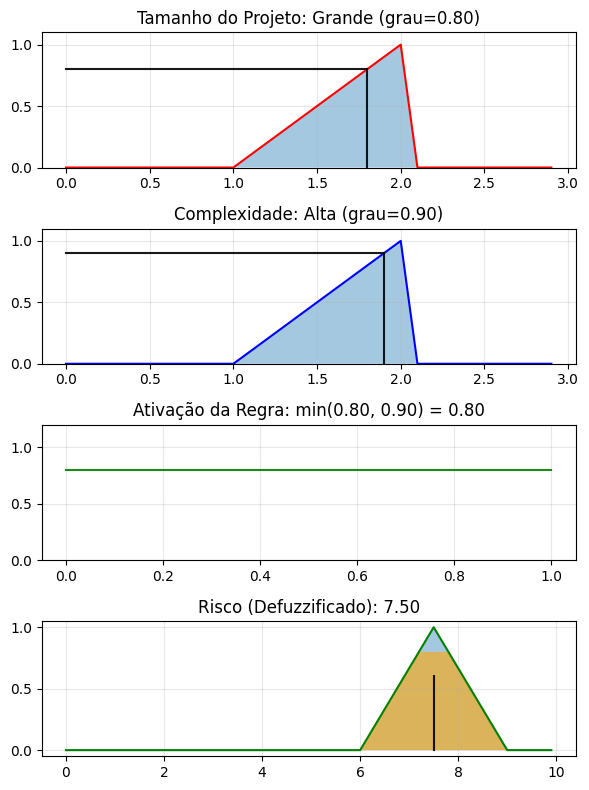


5. GERAÇÃO AUTOMÁTICA DE REGRAS
Gerando regras fuzzy a partir da árvore de decisão...

=== ÁRVORE DE DECISÃO GERADA ===
|--- Schedule_Deviation_Percentage <= -1.29
|   |--- Budget_Deviation_Percentage <= 33.64
|   |   |--- Complexity_Level_Numeric <= 0.50
|   |   |   |--- class: muito_alto
|   |   |--- Complexity_Level_Numeric >  0.50
|   |   |   |--- Project_Size_Numeric <= 0.50
|   |   |   |   |--- class: alto
|   |   |   |--- Project_Size_Numeric >  0.50
|   |   |   |   |--- class: muito_alto
|   |--- Budget_Deviation_Percentage >  33.64
|   |   |--- class: muito_alto
|--- Schedule_Deviation_Percentage >  -1.29
|   |--- Schedule_Deviation_Percentage <= 0.84
|   |   |--- class: alto
|   |--- Schedule_Deviation_Percentage >  0.84
|   |   |--- Schedule_Deviation_Percentage <= 4.12
|   |   |   |--- Schedule_Deviation_Percentage <= 2.82
|   |   |   |   |--- class: alto
|   |   |   |--- Schedule_Deviation_Percentage >  2.82
|   |   |   |   |--- class: muito_alto
|   |   |--- Schedule_Dev

In [7]:
# Run all
def executar_analise_completa():
    print("=== SISTEMA DE ANÁLISE DE RISCO PARA PROJETOS DE SOFTWARE ===")
    
    # 1. Visualizar as funções de pertinência
    print("\n1. VISUALIZAÇÃO DAS FUNÇÕES DE PERTINÊNCIA")
    visualizar_funcoes_pertinencia()
    
    # 2. Criar o sistema fuzzy com regras manuais
    print("\n2. CRIAÇÃO DO SISTEMA FUZZY COM REGRAS MANUAIS")
    simulacao_risco_manual = criar_sistema_fuzzy()
    
    # 3. Avaliar o sistema manual com dados reais
    print("\n3. AVALIAÇÃO DO SISTEMA MANUAL")
    resultados_manual = avaliar_sistema_fuzzy(simulacao_risco_manual, df)
    
    # 4. Demonstração visual da inferência fuzzy
    print("\n4. DEMONSTRAÇÃO DO PROCESSO DE INFERÊNCIA")
    demonstrar_inferencia_fuzzy()
    
    # 5. Gerar regras automáticas a partir da árvore de decisão
    print("\n5. GERAÇÃO AUTOMÁTICA DE REGRAS")
    regras_auto = gerar_regras_automaticamente(df)
    
    # 6. Criar o sistema fuzzy automático
    if regras_auto and len(regras_auto) > 0:
        print("\n6. CRIAÇÃO DO SISTEMA FUZZY COM REGRAS AUTOMÁTICAS")
        sistema_risco_auto = ctrl.ControlSystem(regras_auto)
        simulacao_risco_auto = ctrl.ControlSystemSimulation(sistema_risco_auto)
        print(f"Sistema fuzzy automático criado com {len(regras_auto)} regras!")
        
        # 7. Comparar os sistemas manual e automático
        print("\n7. COMPARAÇÃO ENTRE SISTEMAS MANUAL E AUTOMÁTICO")
        resultados_comparacao = comparar_sistemas(df, simulacao_risco_manual, simulacao_risco_auto)
    
    # 8. Testar com exemplos concretos
    print("\n8. ANÁLISE DE CASOS ESPECÍFICOS")
    print("\n8.1. PROJETO DE ALTO RISCO")
    projeto_alto_risco = {
        'Project_Size': 'Large',
        'Team_Experience_Level': 'Low',
        'Complexity_Level': 'High',
        'Requirement_Stability': 'Unstable',
        'Budget_Deviation_Percentage': 30.0,
        'Schedule_Deviation_Percentage': 15.0
    }
    prever_risco(simulacao_risco_manual, projeto_alto_risco)
    
    print("\n8.2. PROJETO DE BAIXO RISCO")
    projeto_baixo_risco = {
        'Project_Size': 'Small',
        'Team_Experience_Level': 'High',
        'Complexity_Level': 'Low',
        'Requirement_Stability': 'Stable',
        'Budget_Deviation_Percentage': -5.0,
        'Schedule_Deviation_Percentage': 2.0
    }
    prever_risco(simulacao_risco_manual, projeto_baixo_risco)
    
    return simulacao_risco_manual, simulacao_risco_auto if 'simulacao_risco_auto' in locals() else None

simulacao_manual, simulacao_auto = executar_analise_completa()